## Load libraries

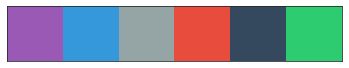

In [16]:
# Toolbox
from pathlib import Path
from PIL import Image
import os
import numpy as np
import pandas as pd 
import seaborn as sns
import random
import sys
import matplotlib.pyplot as plt
%matplotlib inline

# Deep learning libraries
from keras.models import Model, Sequential
from keras.layers import Input, Dense, Flatten, Dropout, BatchNormalization
from keras.layers import Conv2D, SeparableConv2D, MaxPool2D, LeakyReLU, ReLU, Activation
from keras.optimizers import Adam, SGD, RMSprop
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
import keras
import tensorflow as tf
import tensorflow.keras
import cv2

# Machine Learning libraries
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix

# Misc
import os
import warnings
warnings.filterwarnings(action='ignore')

# Preset data display
pd.options.display.max_seq_items = 1000
pd.options.display.max_rows =1000
pd.set_option('display.max_columns', 50)

# Set notebook colors and palette
flatui = ['#9b59b6', '#3498db', '#95a5a6', '#e74c3c', '#34495e', '#2ecc71']
sns.set_palette(flatui)
sns.palplot(sns.color_palette(flatui))
sns.set_style('white')
sns.set_color_codes(palette='deep')
# Favorite code to use: #34995e

# Setting seeds for reproducibility
seed = 100
np.random.seed(seed)
tf.set_random_seed(seed)

In [15]:
print('These are the current versions working for me as of 2019-08-07')
print(f"OpenCV Version: {cv2.__version__}")
print(f"TensorFlow Version: {tf.__version__}")
print(f"TensorFlow Keras Version: {tensorflow.keras.__version__}")
print(f"Keras Version: {keras.__version__}")
print()
print("TensorFlow-GPU is", "available" if tf.test.is_gpu_available() else "NOT AVAILABLE")
print(f"TensorFlow CUDA: {tf.test.is_built_with_cuda()}")
print(f"Tensorflow GPU Device Currently Activated: {tf.test.gpu_device_name()}")
print(f"Keras GPU: {keras.backend.tensorflow_backend._get_available_gpus()}")
print()
print(f"TF Session: {tf.Session()}")
print()
print(f"Python {sys.version}")

These are the current versions working for me as of 2019-08-07
OpenCV Version: 4.0.1
TensorFlow Version: 1.13.1
TensorFlow Keras Version: 2.2.4-tf
Keras Version: 2.2.4

TensorFlow-GPU is available
TensorFlow CUDA: True
Tensorflow GPU Device Currently Activated: /device:GPU:0
Keras GPU: ['/job:localhost/replica:0/task:0/device:GPU:0']

TF Session: <tensorflow.python.client.session.Session object at 0x0000020B10E07208>

Python 3.6.8 |Anaconda, Inc.| (default, Feb 21 2019, 18:30:04) [MSC v.1916 64 bit (AMD64)]


## Set directory

In [17]:
# Set directory
PATH = 'C:\\Users\\' + os.getlogin() + '\\Documents\\Programming\\DeepLearning\\07-pneunomia-radiograph-imaging'
os.chdir(PATH)
os.getcwd()
os.listdir()

['.gitignore',
 '.ipynb_checkpoints',
 '01-notebook.ipynb',
 'environment.yml',
 'etc',
 'images',
 'input',
 'README.md']